# 1. Install Dependencies and Setup

In [ ]:
%pip install tensorflow opencv-python matplotlib scipy

In [ ]:
%pip list

In [13]:
import tensorflow as tf
import os
import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import numpy as np

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [15]:
tf.config.list_physical_devices('GPU')

[]

# 2. Load Data

In [16]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [17]:
data_dir = 'data'

In [18]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(224,224))

Found 305 files belonging to 2 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

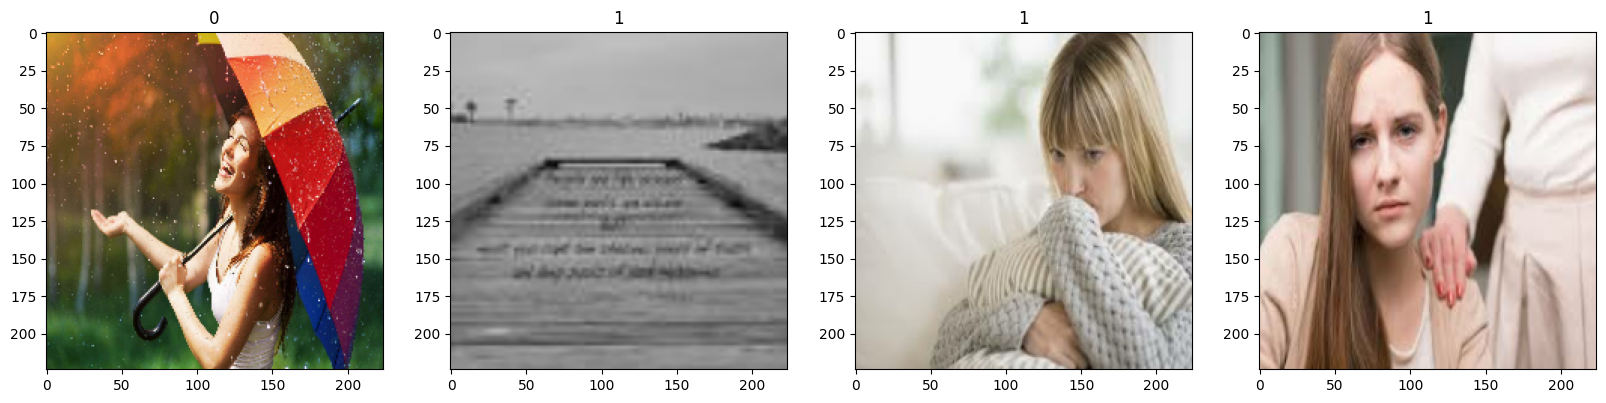

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 3. Scale Data

In [22]:
data = data.map(lambda x,y: (x/255, y))

In [23]:
data.as_numpy_iterator().next()

(array([[[[1.        , 0.972549  , 0.9411765 ],
          [1.        , 0.9764706 , 0.94509804],
          [1.        , 0.9764706 , 0.94509804],
          ...,
          [1.        , 0.9607843 , 0.92941177],
          [0.9980775 , 0.9588618 , 0.9274893 ],
          [0.99215686, 0.9529412 , 0.92156863]],
 
         [[1.        , 0.9764706 , 0.94509804],
          [1.        , 0.9764706 , 0.94509804],
          [1.        , 0.9764706 , 0.94509804],
          ...,
          [0.9942544 , 0.9550387 , 0.9236662 ],
          [0.99607843, 0.95686275, 0.9254902 ],
          [0.99607843, 0.95686275, 0.9254902 ]],
 
         [[1.        , 0.975128  , 0.94375545],
          [1.        , 0.9764706 , 0.94509804],
          [1.        , 0.9764706 , 0.94509804],
          ...,
          [0.99965864, 0.96044296, 0.9290704 ],
          [0.99607843, 0.95686275, 0.9254902 ],
          [0.99607843, 0.95686275, 0.9254902 ]],
 
         ...,
 
         [[0.4439421 , 0.3975664 , 0.2530234 ],
          [0.42996

# 4. Split Data

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
# Initialize the model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()
# Total params: 14,714,688
# Trainable params: 0
# Non-trainable params: 14,714,688

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
x = base_model.output
x = Flatten(name='flatten', input_shape=base_model.output_shape)(x) 
x = Dense(2, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Total params: 14,965,578
# Trainable params: 250,890
# Non-trainable params: 14,714,688

C:\Users\syfur.shohag\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Train

In [30]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=10, validation_data= val, callbacks=[tensorboard_callback])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.4679 - loss: 0.9704 - val_accuracy: 0.8594 - val_loss: 0.3829
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.8312 - loss: 0.3874 - val_accuracy: 0.9531 - val_loss: 0.1907
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9393 - loss: 0.1980 - val_accuracy: 0.9844 - val_loss: 0.1061
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.9836 - loss: 0.1170 - val_accuracy: 0.9688 - val_loss: 0.0938
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9776 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.0467
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9952 - loss: 0.0455 - val_accuracy: 0.9844 - val_loss: 0.0408
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.9893 - loss: 0.0470 - val_accuracy: 1.0000 - val_loss: 0.0255
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9868 - loss: 0.0409 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 9/

In [32]:
hist.history['accuracy']

[0.5223214030265808,
 0.8616071343421936,
 0.9419642686843872,
 0.9866071343421936,
 0.9776785969734192,
 0.9955357313156128,
 0.9955357313156128,
 0.9910714030265808,
 0.9910714030265808,
 0.9910714030265808]

In [33]:
np.mean(hist.history['accuracy'])

0.9254464209079742

In [34]:
np.mean(hist.history['val_accuracy'])

0.9734375

# 7. Plot Performance

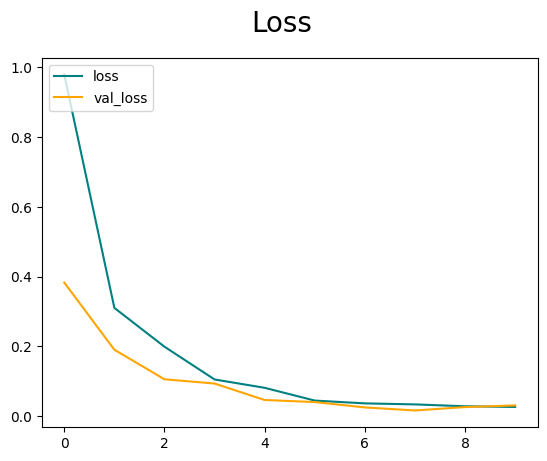

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

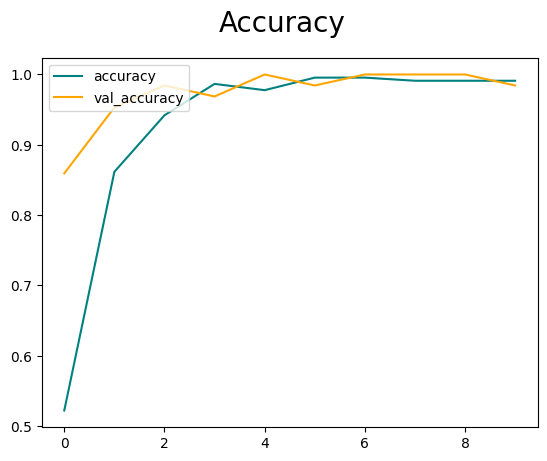

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Use np.argmax to get the predicted class indices
    y_pred = np.argmax(yhat, axis=1)

    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [40]:
print("Precision:", pre.result().numpy())
print("Recall:", re.result().numpy())
print("Accuracy:", acc.result().numpy())

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


# 9. Test

In [41]:
import cv2

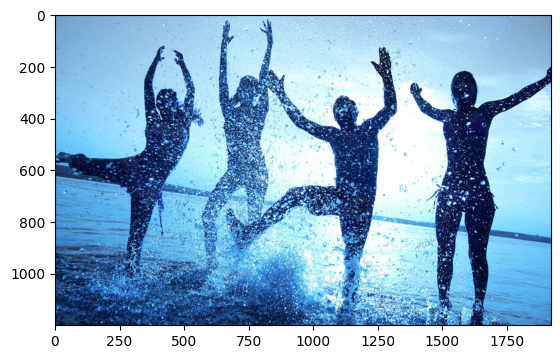

In [42]:
img = cv2.imread('data/happy/1902539.jpg')
plt.imshow(img)
plt.show()

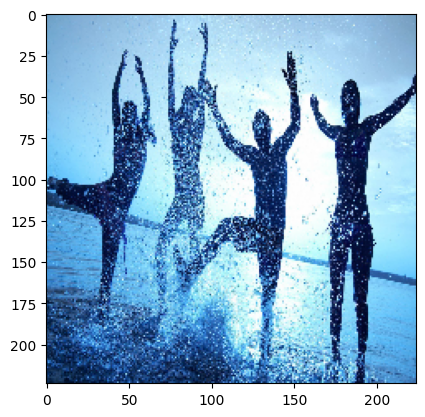

In [43]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


In [45]:
yhat

array([[0.9959282, 0.0040718]], dtype=float32)

In [46]:
class_names = ['happy', 'sad',]
max_index = tf.argmax(yhat, axis=1)
print(max_index)
predicted_class = class_names[max_index[0]]
print("Predicted class:", predicted_class)

tf.Tensor([0], shape=(1,), dtype=int64)
Predicted class: happy


# 10. Save the Model

In [47]:
model.save(os.path.join('models','VGG16.keras'))

# 11. Evaluated from the Saved Model

In [48]:
from tensorflow.keras.models import load_model

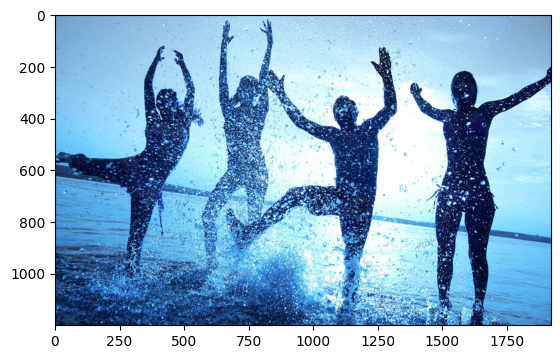

In [49]:
img = cv2.imread('data/happy/1902539.jpg')
plt.imshow(img)
plt.show()

In [50]:
new_model = load_model('models/VGG16.keras')

In [53]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


array([[0.9959282, 0.0040718]], dtype=float32)

In [54]:
class_names = ['happy', 'sad',]
max_index = tf.argmax(yhat, axis=1)
print(max_index)
predicted_class = class_names[max_index[0]]
print("Predicted class:", predicted_class)

tf.Tensor([0], shape=(1,), dtype=int64)
Predicted class: happy
